# Clean atlas data

Here we clean the data from the atlas.

In [1]:
import glob
import os
import os.path

import pandas as pd
import scmdata
import scmdata.database
import tqdm.autonotebook as tqdman

/Users/znicholls/miniconda3/envs/netcdf-scm/lib/python3.8/site-packages/scmdata/database.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


In [2]:
DATA_ROOT = os.path.join("..", "data")

In [3]:
DATA_DIR = os.path.join(DATA_ROOT, "raw", "atlas-data", "data")

In [4]:
OUT_DIR = os.path.join(DATA_ROOT, "processed", "atlas-data")

In [5]:
def rename_region(r):
    if r == "world":
        return "World"
    
    return f"World|AR6 reference regions|{r}"


def read_atlas_file(fpath):
    with open(fpath, "r") as fh:
        for i in range(7):
            line = fh.readline().strip()
            if "Variable" in line:
                variable = line.split(": ")[-1]
            if "Dataset" in line:
                ids = line.split(": ")[-1].split("_")
                scenario = ids[-1]
                ensemble_member = ids[-2]
                mip_era = ids[0].replace("Amon", "")
                climate_model = ids[1]
            if "Area" in line:
                mask = line.split(": ")[-1]

        if variable == "tas":
            unit = "degC"

        data = pd.read_csv(fh, index_col=0)
        
    data.index.name = "time"
    data = data.T
    data.index.name = "region"
    data = data.reset_index()
    data["region"] = data["region"].apply(rename_region)
    data["variable"] = variable
    data["unit"] = unit
    data["scenario"] = scenario
    data["member_id"] = ensemble_member
    data["mip_era"] = mip_era
    data["climate_model"] = climate_model
    data["model"] = "unspecified"
    data["mask"] = mask

    data = scmdata.ScmRun(data)

    return data

In [6]:
all_data = []
for root, dirs, files in os.walk(DATA_DIR):
    if "_pr_" in root:
        continue
    
    if not files:
        continue
        
    for f in tqdman.tqdm(files, desc=root, leave=True):
        all_data.append(read_atlas_file(os.path.join(root, f)))

In [7]:
all_data  = scmdata.run_append(all_data)
all_data

<scmdata.ScmRun (timeseries: 30540, timepoints: 3012)>
Time:
	Start: 1850-01-07T00:00:00
	End: 2100-12-07T00:00:00
Meta:
	      climate_model     mask member_id mip_era        model  \
	0       BCC-CSM2-MR  landsea  r1i1p1f1   CMIP6  unspecified   
	1       BCC-CSM2-MR  landsea  r1i1p1f1   CMIP6  unspecified   
	2       BCC-CSM2-MR  landsea  r1i1p1f1   CMIP6  unspecified   
	3       BCC-CSM2-MR  landsea  r1i1p1f1   CMIP6  unspecified   
	4       BCC-CSM2-MR  landsea  r1i1p1f1   CMIP6  unspecified   
	...             ...      ...       ...     ...          ...   
	30535     NorESM1-M      sea    r1i1p1   CMIP5  unspecified   
	30536     NorESM1-M      sea    r1i1p1   CMIP5  unspecified   
	30537     NorESM1-M      sea    r1i1p1   CMIP5  unspecified   
	30538     NorESM1-M      sea    r1i1p1   CMIP5  unspecified   
	30539     NorESM1-M      sea    r1i1p1   CMIP5  unspecified   
	
	                                region    scenario  unit variable  
	0      World|AR6 reference regions|GIC 

In [8]:
db = scmdata.database.ScmDatabase(
    OUT_DIR,
    levels=("scenario", "climate_model", "mip_era"),
)
db

<scmdata.database.SCMDatabase (root_dir: ../data/processed/atlas-data, levels: ('scenario', 'climate_model', 'mip_era'))>

In [9]:
all_data.meta[["scenario", "climate_model", "mip_era"]].drop_duplicates()

scenario  climate_model mip_era
0      historical    BCC-CSM2-MR   CMIP6
56         ssp126    CNRM-ESM2-1   CMIP6
112    historical       GFDL-CM4   CMIP6
168        ssp245    CNRM-ESM2-1   CMIP6
224        ssp585          CESM2   CMIP6
...           ...            ...     ...
13693       rcp45      NorESM1-M   CMIP5
13752  historical        BNU-ESM   CMIP5
13811       rcp85       GFDL-CM3   CMIP5
13870  historical  CSIRO-Mk3-6-0   CMIP5
13929       rcp85      NorESM1-M   CMIP5

[173 rows x 3 columns]

In [11]:
db.save(all_data)

In [12]:
db.available_data()

scenario climate_model mip_era
0    historical     ACCESS1-0   CMIP5
1    historical     ACCESS1-3   CMIP5
2    historical   BCC-CSM2-MR   CMIP6
3    historical       BNU-ESM   CMIP5
4    historical   CAMS-CSM1-0   CMIP6
..          ...           ...     ...
168      ssp585  IPSL-CM6A-LR   CMIP6
169      ssp585    MIROC-ES2L   CMIP6
170      ssp585        MIROC6   CMIP6
171      ssp585    MRI-ESM2-0   CMIP6
172      ssp585         NESM3   CMIP6

[173 rows x 3 columns]

In [13]:
plotter = scmdata.ScmRun(
    all_data
    .filter(region="World", mask="landsea")
    .time_mean("AC")
    .process_over("member_id", "mean")
)
plotter.head()

time                                                                       1850-07-01  \
climate_model mask    mip_era model       region scenario   unit variable               
ACCESS1-0     landsea CMIP5   unspecified World  historical degC tas        14.694500   
ACCESS1-3     landsea CMIP5   unspecified World  historical degC tas        15.033833   
BNU-ESM       landsea CMIP5   unspecified World  historical degC tas              NaN   
CCSM4         landsea CMIP5   unspecified World  historical degC tas        13.121167   
CESM1-BGC     landsea CMIP5   unspecified World  historical degC tas        13.431667   

time                                                                       1851-07-01  \
climate_model mask    mip_era model       region scenario   unit variable               
ACCESS1-0     landsea CMIP5   unspecified World  historical degC tas        14.577000   
ACCESS1-3     landsea CMIP5   unspecified World  historical degC tas        15.194583   
BNU-ESM       landsea CMIP5   unspecified World  historical degC tas              NaN   
CCSM4         landsea CMIP5   unspecified World  historical degC tas        13.322417   
CESM1-BGC     landsea CMIP5   unspecified World  historical degC tas        13.349083   

time                                                                       1852-07-01  \
climate_model mask    mip_era model       region scenario   unit variable               
ACCESS1-0     landsea CMIP5   unspecified World  historical degC tas        14.601417   
ACCESS1-3     landsea CMIP5   unspecified World  historical degC tas        15.110083   
BNU-ESM       landsea CMIP5   unspecified World  historical degC tas              NaN   
CCSM4         landsea CMIP5   unspecified World  historical degC tas        13.364000   
CESM1-BGC     landsea CMIP5   unspecified World  historical degC tas        13.146667   

time                                                                       1853-07-01  \
climate_model mask    mip_era model       region scenario   unit variable               
ACCESS1-0     landsea CMIP5   unspecified World  historical degC tas        14.793917   
ACCESS1-3     landsea CMIP5   unspecified World  historical degC tas        15.191417   
BNU-ESM       landsea CMIP5   unspecified World  historical degC tas              NaN   
CCSM4         landsea CMIP5   unspecified World  historical degC tas        13.248250   
CESM1-BGC     landsea CMIP5   unspecified World  historical degC tas        13.278750   

time                                                                       1854-07-01  \
climate_model mask    mip_era model       region scenario   unit variable               
ACCESS1-0     landsea CMIP5   unspecified World  historical degC tas        14.836250   
ACCESS1-3     landsea CMIP5   unspecified World  historical degC tas        15.327000   
BNU-ESM       landsea CMIP5   unspecified World  historical degC tas              NaN   
CCSM4         landsea CMIP5   unspecified World  historical degC tas        13.037917   
CESM1-BGC     landsea CMIP5   unspecified World  historical degC tas        13.364417   

time                                                                       1855-07-01  \
climate_model mask    mip_era model       region scenario   unit variable               
ACCESS1-0     landsea CMIP5   unspecified World  historical degC tas        14.793667   
ACCESS1-3     landsea CMIP5   unspecified World  historical degC tas        15.074500   
BNU-ESM       landsea CMIP5   unspecified World  historical degC tas              NaN   
CCSM4         landsea CMIP5   unspecified World  historical degC tas        13.216500   
CESM1-BGC     landsea CMIP5   unspecified World  historical degC tas        13.502833   

time                                                                       1856-07-01  \
climate_model mask    mip_era model       region scenario   unit variable               
ACCESS1-0     landsea CMIP5   unspecified World  historical degC tas        14

<AxesSubplot:xlabel='time', ylabel='degC'>

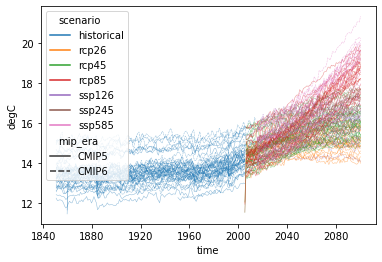

In [14]:
plotter.lineplot(
    hue_order=sorted(plotter.get_unique_meta("scenario")),
    style="mip_era", 
    units="climate_model", 
    estimator=None, 
    linewidth=0.5, 
    alpha=0.5
)